In [ ]:
%pip install langgraph

# LanGraph Intro

LangGraph 是一個用於建立複雜、狀態化的多AI代理系統的革命性框架，特別適用於與大型語言模型 (LLM) 合作。LangGraph 以圖形結構為基礎，將每個 AI 代理視為節點，而代理之間的資訊傳遞則以邊來呈現。它提供狀態管理功能，讓代理能夠在執行任務時更新自身的狀態，並保持上下文連貫性。此外，LangGraph 還具備協調能力，確保代理按正確順序執行任務，並有效地交換資訊。透過這些特性，LangGraph 簡化了開發流程，讓開發者可以更專注於應用的高階邏輯。LangGraph 適用於各種場景，例如智能客服系統、工作流程自動化、多代理協作系統、智能推薦系統以及個人化學習平台等。文章詳細介紹了 LangGraph 的核心概念、應用場景、使用方法以及優缺點，旨在讓讀者了解 LangGraph 的強大功能，並鼓勵他們開始使用這個工具來開發更智能的 AI 應用。



圖結構（Graph Structure）：AI 應用的骨架
LangGraph 採用有向圖（Directed Graph）來描述應用程式結構。想像將你的應用程式描述成一張有向圖，LangGraph 世界中，將每一個節點(Node) 都代表一個代理人，邊(edge) 則是代理人之間傳遞資訊的通道。利用這種清晰的結構且可管理的工作流程，每個代理人可以執行特定任務之外也能將資訊傳遞給其他代理。

- 節點（Node）：代表各個智能代理
- 邊（Edge）：代表代理之間的信息傳遞通道

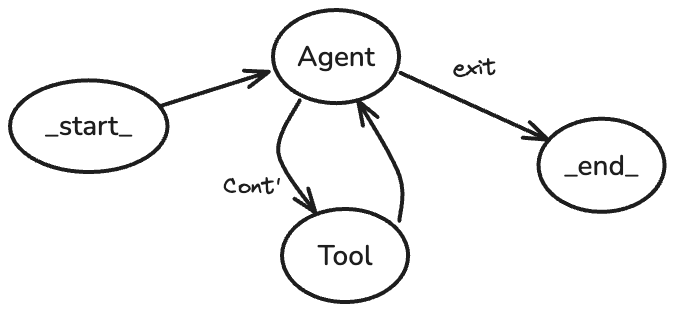

狀態管理（State Management）
LangGraph 的狀態管理功能就像是給 AI 安裝了一個超級記憶體。當 AI 代理執行任務時，它們可以即時更新自己的狀態，確保系統能夠維持上下文的連貫性，並對輸入做出最恰當的回應。這項功能讓開發者能夠在多輪對話中追蹤和保留關鍵資訊，大大提升了 AI 應用的智慧程度和使用體驗。

LangGraph 的動態狀態更新機制確保系統能夠：

- 維護上下文
- 對輸入做出適當回應
- 在多次交互中追踪和保留關鍵信息

協調（Coordination）
LangGraph 的協調功能就像是一位精明的指揮家，確保每個 AI 代理都能在正確的時機演奏出最美妙的音符。通過精確管理資料流和操作順序，LangGraph 讓開發者能夠專注於設計應用的高階邏輯，而無需陷入繁瑣的協調細節中。

LangGraph 的協調功能確保：

- 代理按正確順序執行任務
- 信息在代理間無縫交換
- 開發者可專注於應用程序的高階邏輯


💡 亮點：LangGraph 的協調功能極大地簡化了複雜多代理系統的開發流程，使得構建高度智能化的應用變得前所未有的簡單。

教學：

https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements

## Concept

# Conversational RAG

In [3]:
from typing import Sequence

import bs4
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

import os
from dotenv import load_dotenv

load_dotenv("/Users/wenye/ML&AI Tutor/.env.local")

OPENAI_KEY = os.getenv("OPENAI_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_KEY)
OPENAI_EMBEDDING = OpenAIEmbeddings(api_key=OPENAI_KEY)


### Construct retriever ###
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=OPENAI_EMBEDDING
)
retriever = vectorstore.as_retriever()


### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str


def call_model(state: State):
    response = rag_chain.invoke(state)
    return {
        "chat_history": [
            HumanMessage(state["input"]),
            AIMessage(response["answer"]),
        ],
        "context": response["context"],
        "answer": response["answer"],
    }


workflow = StateGraph(state_schema=State)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [4]:
config = {"configurable": {"thread_id": "abc123"}}

result = app.invoke(
    {"input": "What is Task Decomposition?"},
    config=config,
)
print(result["answer"])

Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. It utilizes techniques like Chain of Thought (CoT) to enhance model performance by encouraging a step-by-step approach, allowing for easier handling of complex tasks. This can be achieved through simple prompting, task-specific instructions, or human inputs.


In [7]:
result = app.invoke(
    {"input": "What is one way of doing it?"},
    config=config,
)
print(result["answer"])

One way of doing task decomposition is by using task-specific instructions, such as directing the model with a prompt like "Write a story outline." This method guides the model to focus on the specific requirements of the task at hand.


In [10]:
result["context"][0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}

In [6]:
chat_history = app.get_state(config).values["chat_history"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. It utilizes techniques like Chain of Thought (CoT) to enhance model performance by encouraging a step-by-step approach, allowing for easier handling of complex tasks. This can be achieved through simple prompting, task-specific instructions, or human inputs.
================================ Human Message =================================

What is one way of doing it?
================================== Ai Message ==================================

One way of doing task decomposition is by using simple prompting, such as asking the model, "Steps for XYZ.\n1." This approach instructs the model to outline the necessary steps to achieve a specific goal, making the task more manageable.


# Agent

https://ithelp.ithome.com.tw/m/articles/10347050

https://r23456999.medium.com/langgraph-%E8%88%87-langfuse-%E6%89%93%E9%80%A0%E6%99%BA%E8%83%BD%E8%A7%80%E6%B8%AC%E7%B3%BB%E7%B5%B1%E7%9A%84%E5%AE%8C%E7%BE%8E%E7%B5%84%E5%90%88-da09e515cf1d